In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import imageio

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [ ]:
!unzip '/content/preprocessed_images2.zip'

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images2/2157_left_80_Female_C.jpg  
  inflating: preprocessed_images2/2157_right_80_Female_C.jpg  
  inflating: preprocessed_images2/2158_left_61_Female_C.jpg  
  inflating: preprocessed_images2/2158_right_61_Female_C.jpg  
  inflating: preprocessed_images2/2159_left_53_Male_C.jpg  
  inflating: preprocessed_images2/216_left_68_Male_D.jpg  
  inflating: preprocessed_images2/216_right_68_Male_O.jpg  
  inflating: preprocessed_images2/2160_left_76_Female_N.jpg  
  inflating: preprocessed_images2/2160_right_76_Female_C.jpg  
  inflating: preprocessed_images2/2161_left_59_Male_D.jpg  
  inflating: preprocessed_images2/2161_right_59_Male_C.jpg  
  inflating: preprocessed_images2/2162_left_63_Male_N.jpg  
  inflating: preprocessed_images2/2162_right_63_Male_C.jpg  
  inflating: preprocessed_images2/2163_left_58_Male_C.jpg  
  inflating: preprocessed_images2/2163_right_58_Male_C.jpg  
  inflating: preprocessed_images

In [ ]:
df = pd.read_csv('/content/full_df_cleaned_v3.csv')

In [ ]:
df

,Diagnostic,file,target_init,Patient Age,Patient Sex,Target,tarstr,N,D,G,C,A,H,M,O,filename
0,normal fundus,0_right.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]",69,Female,"[1, 0, 0, 0, 0, 0, 0, 0]",N,1,0,0,0,0,0,0,0,0_right_69_Female_N.jpg
1,normal fundus,1_right.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]",57,Male,"[1, 0, 0, 0, 0, 0, 0, 0]",N,1,0,0,0,0,0,0,0,1_right_57_Male_N.jpg
2,moderate non proliferative retinopathy,2_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",42,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,2_right_42_Male_D.jpg
3,mild nonproliferative retinopathy,4_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",53,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,4_right_53_Male_D.jpg
4,moderate non proliferative retinopathy,5_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",50,Female,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,5_right_50_Female_D.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6108,mild nonproliferative retinopathy,4394_left.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",56,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,4394_left_56_Male_D.jpg
6109,mild nonproliferative retinopathy,4427_left.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",43,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,4427_left_43_Male_D.jpg
6110,mild nonproliferative retinopathy,4551_left.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",53,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,4551_left_53_Male_D.jpg
6111,moderate non proliferative retinopathy,4601_left.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]",36,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",D,0,1,0,0,0,0,0,0,4601_left_36_Male_D.jpg


In [ ]:
df_n = df[df['tarstr']=='N']

In [ ]:
df_n.shape

(2786, 16)

In [ ]:
df_c = df[df['tarstr']=='C']

In [ ]:
df_c.shape

(260, 16)

In [ ]:
df_N_C = pd.concat([df_n, df_c], ignore_index=True)

In [ ]:
df_N_C.shape

(3046, 16)

In [ ]:
IMAGE_PATH = 'preprocessed_images2//'

In [ ]:
df_N_C['filepath'] = IMAGE_PATH + df_N_C['filename']

In [ ]:
img_data = []
number_id_nofile = []

for i in range(len(df_N_C)):
  try:
    img_data.append(imageio.imread(df_N_C['filepath'][i]))
  except:
    number_id_nofile.append(df_N_C.index[i])

<ipython-input-13-15b1b6606ac9>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_data.append(imageio.imread(df_N_C['filepath'][i]))


In [ ]:
df_N_C = df_N_C.drop(number_id_nofile)

In [ ]:
df_N_C['tarstr'].value_counts()

,count
tarstr,
N,2786
C,260


In [ ]:
img_data_array = np.array(img_data)

In [ ]:
img_data_array.shape

(3046, 256, 256, 3)

In [ ]:
# Preprocess your input images
def preprocess_image(image):
    # Resize the image to match the input size of ResNet50 (usually 224x224 or 299x299)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

X = np.array([preprocess_image(img) for img in img_data])
y = df_N_C['C']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add your custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling layer avg max
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # Fully connected layer
predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.3, epochs=50, batch_size=16, verbose=1)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 32s 174ms/step - accuracy: 0.9099 - loss: 6.6076 - val_accuracy: 0.9672 - val_loss: 0.5882
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.9767 - loss: 0.4309 - val_accuracy: 0.9808 - val_loss: 0.2106
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.9788 - loss: 0.1772 - val_accuracy: 0.9795 - val_loss: 0.1301
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9795 - loss: 0.1385 - val_accuracy: 0.9740 - val_loss: 0.1279
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.9750 - loss: 0.1172 - val_accuracy: 0.9795 - val_loss: 0.1045
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9845 - loss: 0.0861 - val_accuracy: 0.9754 - val_loss: 0.1017
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.9686 - loss: 0.1168 - val_accuracy: 0.9795 - val_loss: 0.0941
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy * 100}%")

Test Loss: 0.092178113758564, Test Accuracy: 97.86885380744934%


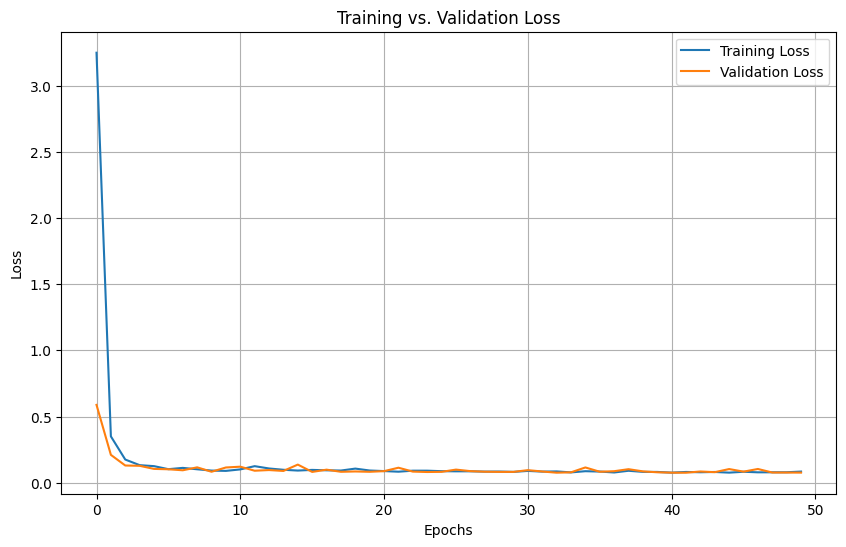

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Saving the model to use it for frontend

In [ ]:
model.save('Ocular_disease.h5')

**Input from User**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

def preprocess_single_image(image):
    image = tf.image.resize(image, (224, 224))  # Resize to match the input size of ResNet50
    image = preprocess_input(image)  # Apply ResNet50-specific preprocessing
    return image


In [ ]:
from PIL import Image
import numpy as np

def load_image(file_path):
    image = Image.open(file_path)
    # Convert the image to a NumPy array
    image_array = np.array(image)
    return image_array


In [ ]:
# Load the saved model (assuming you've already saved it)
model = tf.keras.models.load_model('Ocular_disease.h5')  # Replace with your actual model path

# Load and preprocess the individual image
image = load_image("/content/preprocessed_images2/0_left_69_Female_C.jpg")  # Replace with the path to your image
preprocessed_image = preprocess_single_image(image)

# Make a prediction
prediction = model.predict(np.expand_dims(preprocessed_image, axis=0))

# You'll get a probability value; you can threshold it for binary classification
if prediction > 0.5:
    disease_class = 'Disease.'  # Your positive class
else:
    disease_class = 'No Disease'  # Your negative class

print(f"Predicted class: \033[92m{disease_class}\033[0m")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: Disease.
